In [1]:
%matplotlib inline
from wcs_utils import apply_wcs_to_photometry, match_catalog, radec2altaz, trim_stars, robustRMS
from astropy.table import Table, vstack, hstack
import numpy as np

from astropy.io import fits
import matplotlib.pylab as plt
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord
from read_ybc import readYBC
import astropy.units as u
import lsst.all_sky_phot.wcs as asp

from scipy.optimize import minimize

In [2]:
# Load up the photometry tables
temp = np.load('full_night.npz')
phot_tables = temp['phot_tables'][()]
temp.close()

# Load up the initial WCS fit
hdulist = fits.open('wcs_asp_only.fits')
w = wcs.WCS(hdulist[0].header)
hdulist.close()

# Load the Yale bright star catalog
ybc = readYBC()
ybc_bright = np.where(ybc['Vmag'].values < 4)
ybc_cat = SkyCoord(ra=ybc['RA'].values[ybc_bright]*u.degree, dec=ybc['Dec'].values[ybc_bright]*u.degree)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less


In [3]:
# get a rough alt and az for each table, and apply a rough photo zeropoint
for ptable in phot_tables:
    ptable = apply_wcs_to_photometry(ptable, w, zp=-18.0)
    ptable = match_catalog(ptable, ybc_cat, ybc['Vmag'].values[ybc_bright])

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
If you need enough precisi

In [4]:
phot_tables[40]

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,residual_aperture_sum,mjd,alt_wcs,az_wcs,ra_wcs,dec_wcs,mag,ra_matched,dec_matched,alt_matched,az_matched,d2d,matched_Vmag,bright_star_idx
,pix,pix,,,,,deg,deg,deg,deg,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
1,3362.02982772,0.558556094908,160193.384914,58396.7546705,108053.425387,57415.0323611,7.69942468139,350.434181456,52.1813914098,50.9045393482,5.41590365263,51.0808333333,49.8611111111,8.54566808959,349.494546877,1.25743796793,1.79,53
2,2733.32986198,0.568254328072,381126.225141,15951.6355576,366883.693393,57415.0323611,10.8479705854,8.30773171718,79.6027095759,48.1221325377,4.08867897645,79.1725,45.9980555556,12.990024007,8.40866782386,2.14418985222,0.08,96
3,3062.95548732,6.90491257689,132546.349572,-14749.3603657,145715.421327,57415.0323611,10.8745961167,358.788214019,65.5219504113,48.8273689702,5.09123620907,55.73125,47.7875,11.2230683505,352.082652605,6.58983470095,3.01,57
4,2851.83809244,10.0827452988,-14763.2061351,-75233.7751428,52409.8073853,57415.0323611,11.5751288325,4.89100979397,74.4875653381,47.8929808456,6.201468591,79.1725,45.9980555556,12.990024007,8.40866782386,3.71660595368,0.08,96
5,3323.81363857,9.97257109029,65756.0969461,52121.4707498,19219.0694909,57415.0323611,8.7182233202,351.418642416,54.0242207455,50.1209993063,7.29066910732,51.0808333333,49.8611111111,8.54566808959,349.494546877,1.90995843843,1.79,53
6,2471.79806414,12.4179324314,1361624.99248,74006.9919978,1295547.32105,57415.0323611,9.66232327087,15.7936318099,90.6335984454,47.3046441649,2.71886679846,89.8820833333,44.9475,12.0560647895,16.1122514528,2.41397070675,1.9,124
7,3741.82772507,11.9035604986,22127.2926396,-1979.72566998,23894.904845,57415.0323611,0.766542999826,340.529956263,32.9413238998,53.7919928666,7.0542367365,42.6741666667,55.8955555556,1.26277268902,346.49047599,5.97973389279,3.76,41
8,3184.27713025,14.0637581922,20859.1215888,15592.8677765,6936.91821696,57415.0323611,10.4115028223,355.298928211,60.2641524938,49.0486263632,8.397083564,55.73125,47.7875,11.2230683505,352.082652605,3.26140698038,3.01,57


/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


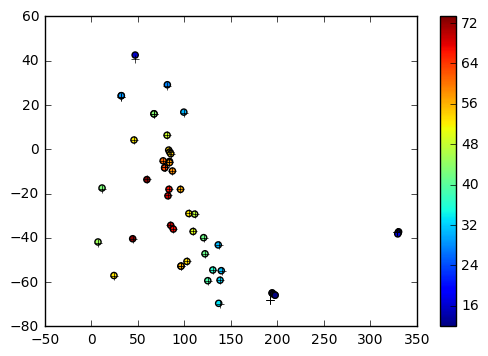

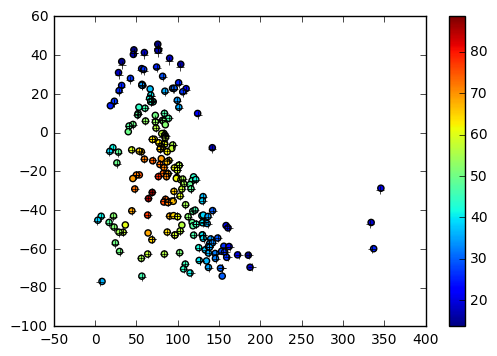

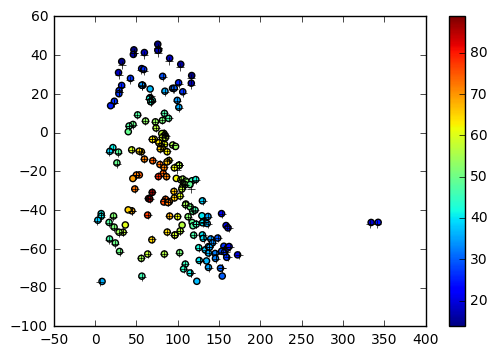

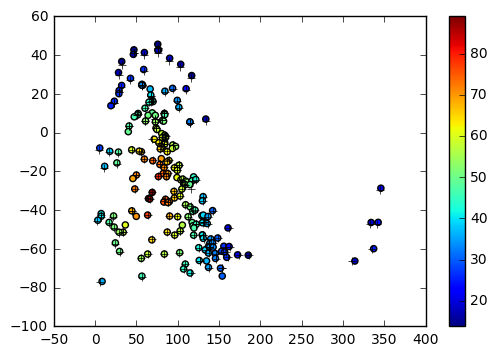

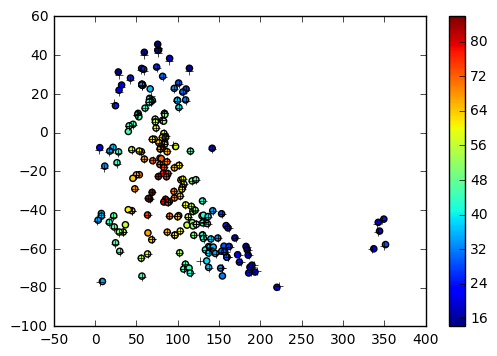

In [5]:
for i in [20, 40, 41, 42,60]:
    plt.figure()
    matched = np.where((phot_tables[i]['d2d'] < 5.) & (phot_tables[i]['d2d'] > 0.) &
                       (np.abs(phot_tables[i]['mag']-phot_tables[i]['matched_Vmag']) < 3) &
                       (phot_tables[i]['mag'] < 4.) & (phot_tables[i]['alt_matched'] > 15.))
    plt.scatter(phot_tables[i]['ra_wcs'][matched], phot_tables[i]['dec_wcs'][matched], 
                c=phot_tables[i]['alt_wcs'][matched])
    plt.plot(phot_tables[i]['ra_matched'][matched], phot_tables[i]['dec_matched'][matched],'k+' )
    plt.colorbar()

In [6]:
print matched[0].size
print np.size(np.unique(phot_tables[i]['bright_star_idx'][matched]))

201
165


In [7]:
phot_array = np.hstack([pt.as_array() for pt in phot_tables if len(pt) > 0])

In [8]:
phot_array.shape

(2985981,)

In [9]:
good = np.where((phot_array['bright_star_idx'] == 130) & (phot_array['d2d'] < 1.) &
                (np.abs(phot_array['mag']-phot_array['matched_Vmag']) < 1.5))
good[0].size

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


43

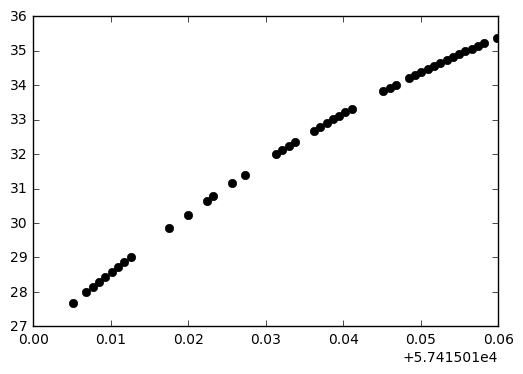

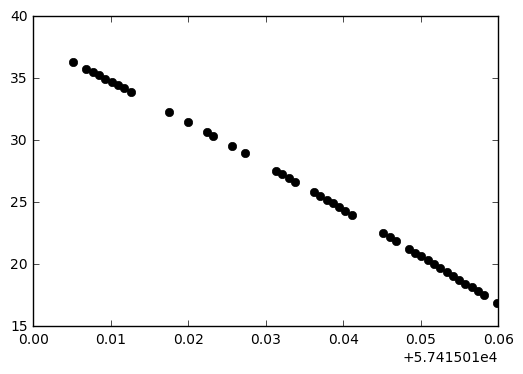

In [10]:
#plt.scatter(phot_array['xcenter'][good], phot_array['ycenter'][good], c=phot_array['mjd'][good])
plt.plot(phot_array['mjd'][good], phot_array['alt_matched'][good], 'ko')
plt.figure()
plt.plot(phot_array['mjd'][good], phot_array['az_matched'][good], 'ko')

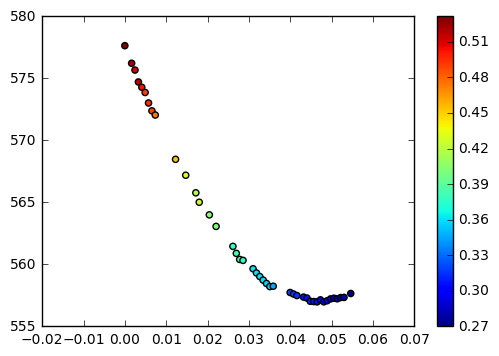

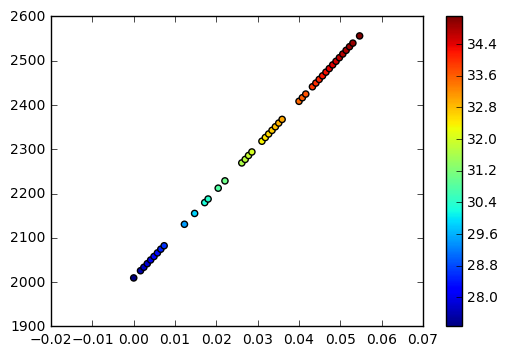

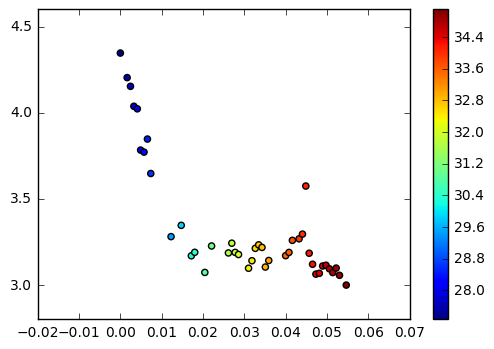

In [11]:
t0=phot_array['mjd'][good].min()
plt.scatter(phot_array['mjd'][good]-t0, phot_array['ycenter'][good], c=phot_array['d2d'][good])
plt.colorbar()
plt.figure()
plt.scatter(phot_array['mjd'][good]-t0, phot_array['xcenter'][good], c=phot_array['alt_wcs'][good])
cb = plt.colorbar()
plt.figure()
plt.scatter(phot_array['mjd'][good]-t0, phot_array['mag'][good], c=phot_array['alt_wcs'][good])
cb = plt.colorbar()

In [12]:
# Now I need to go through each unique star and decide which match it really belongs to I guess.

In [13]:
goodtrimmed = np.where( (phot_array['d2d'] < 1.) &
                (np.abs(phot_array['mag']-phot_array['matched_Vmag']) < 1.5) &
               (phot_array['alt_matched'] > 5.))
good = trim_stars(phot_array[goodtrimmed])

good = goodtrimmed[0][np.where(good == True)]
print 'down to %i unique stars' %np.size(np.unique(phot_array['bright_star_idx'][good]))

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


found 206 unque stars
down to 197 unique stars


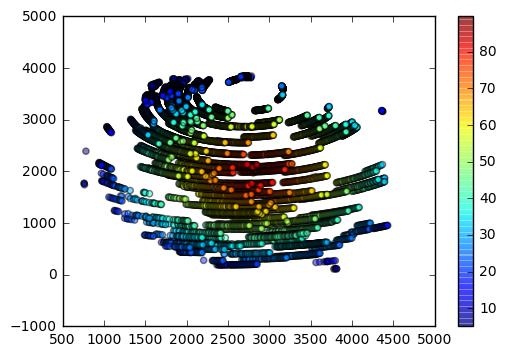

In [14]:
plt.scatter(phot_array['xcenter'][good], phot_array['ycenter'][good], c=phot_array['alt_matched'][good], alpha=.5)
cb = plt.colorbar()

In [15]:
# Now to fit the WCS to a full night.
fun_sip = asp.wcs_azp(phot_array['xcenter'][good], phot_array['ycenter'][good],
                      phot_array['alt_matched'][good], phot_array['az_matched'][good],
                      a_order=5, b_order=5)

In [16]:
# Load up simple fit:
hdulist = fits.open('wcs_asp_only.fits')
w = wcs.WCS(hdulist[0].header)
hdulist.close()


In [17]:
# Generate an intial guess
x0 = np.zeros(fun_sip.b_ind.max()+1)
xold = fun_sip.wcs2x0(w)
x0[0:xold.size] = xold

In [18]:
fit_result_sip = minimize(fun_sip, x0, method='Powell')

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [19]:
wcs_full_night = fun_sip.return_wcs(fit_result_sip.x)

In [20]:
#x,y = wcs_full_night.all_world2pix(phot_array['az_matched'][good], phot_array['alt_matched'][good],  0)
x,y = wcs_full_night.all_world2pix(phot_array['az_matched'][good], phot_array['alt_matched'][good],  0)

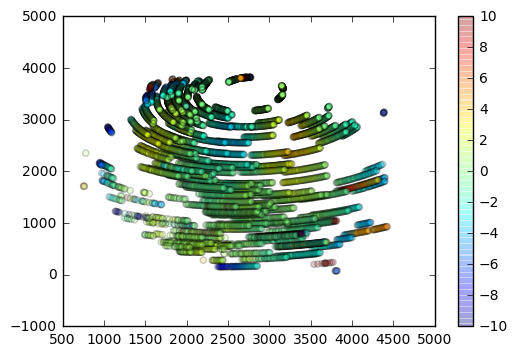

In [21]:
plt.scatter(x,y,c=phot_array['xcenter'][good]-x, vmin=-10, vmax=10, alpha=.2)
plt.colorbar()

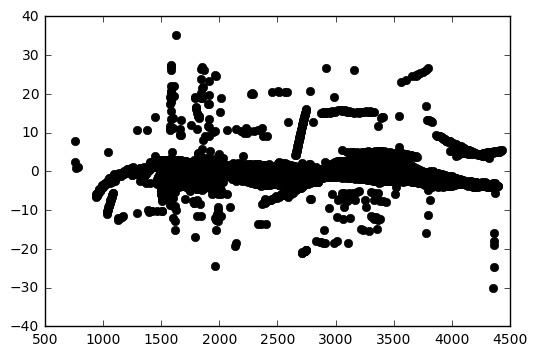

In [22]:
plt.plot(phot_array['xcenter'][good], phot_array['xcenter'][good]-x, 'ko')

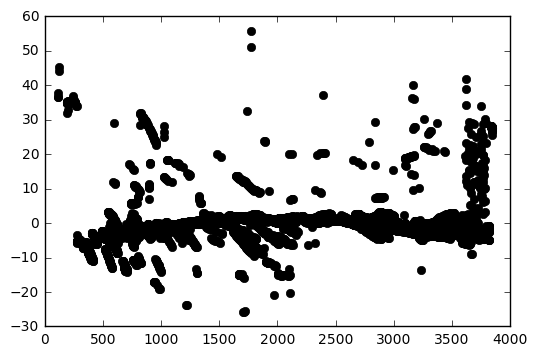

In [23]:
plt.plot(phot_array['ycenter'][good], phot_array['ycenter'][good]-y, 'ko')

In [24]:
# Let's toss some outliers and iterate!
resid_dist = ((phot_array['ycenter'][good]-y)**2+(phot_array['xcenter'][good]-x)**2)**0.5

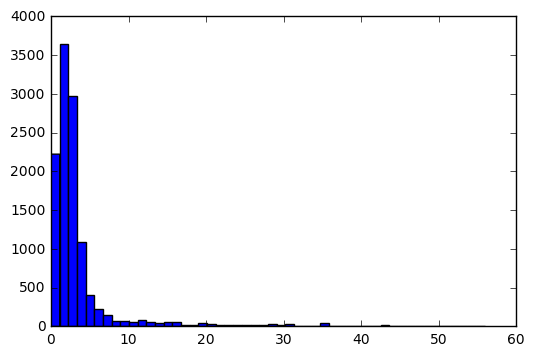

In [25]:
ack = plt.hist(resid_dist, bins=50)

In [26]:
# let's just try iterating the above:
w = wcs_full_night
for ptable in phot_tables:
    ptable = apply_wcs_to_photometry(ptable, w, zp=-18.0)
    ptable = match_catalog(ptable, ybc_cat, ybc['Vmag'].values[ybc_bright])

In [27]:
phot_array = np.hstack([pt.as_array() for pt in phot_tables if len(pt) > 0])

In [28]:
goodtrimmed = np.where( (phot_array['d2d'] < 1.) &
                (np.abs(phot_array['mag']-phot_array['matched_Vmag']) < 1.5) &
               (phot_array['alt_matched'] > 5.))
good = trim_stars(phot_array[goodtrimmed])

good = goodtrimmed[0][np.where(good == True)]
print 'down to %i unique stars' %np.size(np.unique(phot_array['bright_star_idx'][good]))

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


found 239 unque stars
down to 235 unique stars


In [29]:
fun_sip = asp.wcs_azp(phot_array['xcenter'][good], phot_array['ycenter'][good],
                      phot_array['alt_matched'][good], phot_array['az_matched'][good],
                      a_order=5, b_order=5)

In [30]:
x0 = fun_sip.wcs2x0(w)
fit_result_sip = minimize(fun_sip, x0, method='Powell')

/Users/yoachim/gitRepos/all_sky_phot/python/lsst/all_sky_phot/wcs/fit_wcs.py:97: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x0[self.a_ind] = wcs.sip.a.reshape((self.a_order+1.)**2)
/Users/yoachim/gitRepos/all_sky_phot/python/lsst/all_sky_phot/wcs/fit_wcs.py:98: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x0[self.b_ind] = wcs.sip.b.reshape((self.b_order+1.)**2)


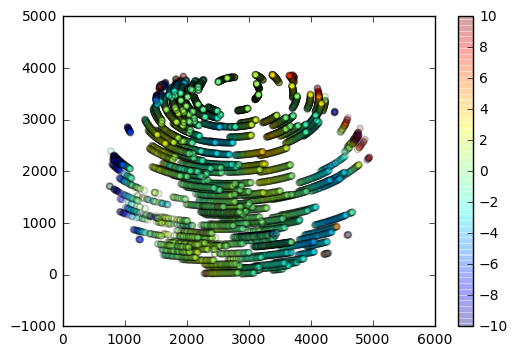

In [31]:
x,y = wcs_full_night.all_world2pix(phot_array['az_matched'][good], phot_array['alt_matched'][good],  0)
plt.scatter(x,y,c=phot_array['xcenter'][good]-x, vmin=-10, vmax=10, alpha=.2)
plt.colorbar()

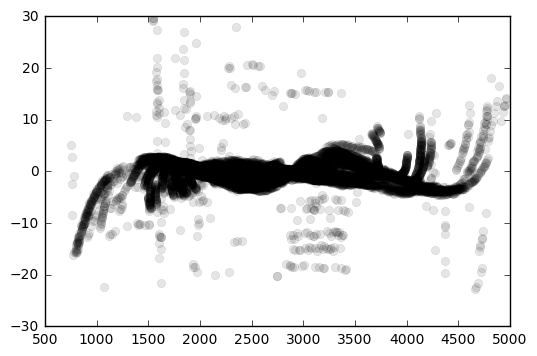

In [32]:
plt.plot(phot_array['xcenter'][good], phot_array['xcenter'][good]-x, 'ko', alpha=.1)

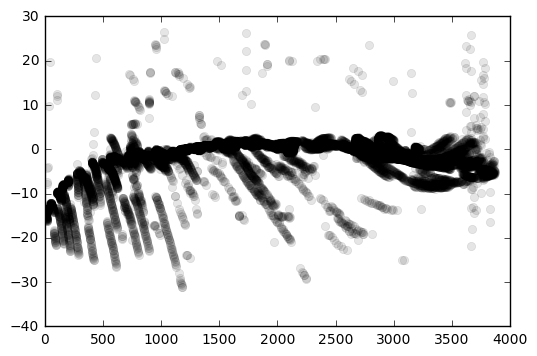

In [33]:
plt.plot(phot_array['ycenter'][good], phot_array['ycenter'][good]-y, 'ko', alpha=.1)

In [47]:
az, alt = wcs_full_night.all_pix2world([3000,3000], [2000,2001],  0)

In [48]:
c1 = SkyCoord(az[0]*u.degree, alt[0]*u.degree)
c2 = SkyCoord(az[1]*u.degree, alt[1]*u.degree)
sep = c1.separation(c2)
print 'seperation between pixels', sep

seperation between pixels 0d02m09.8195s


In [49]:
wcs_full_night

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AZP-SIP'  'DEC--AZP-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 2863.9003577487406  1980.3802791007172  
PC1_1 PC1_2  : 0.032647768932259312  0.0023561941193458078  
PC2_1 PC2_2  : 0.0028045414911100478  -0.034834137393472096  
CDELT : 1.083163230931657  1.000635430877024  
NAXIS    : 0 0

In [50]:
# WORKED! Now to write it out
header = wcs_full_night.to_header(relax=True)
hdu = fits.PrimaryHDU(header=header)
hdu.writeto('wcs_full_night.fits')